In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.arima_model import ARIMA

In [2]:
ds = pd.read_csv("reviews.csv")
ds.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,109,449036,2011-08-15,927861,Edwin & Christi,The host canceled my reservation the day befor...
1,109,74506539,2016-05-15,22509885,Jenn,Me and two friends stayed for four and a half ...
2,344,79805581,2016-06-14,2089550,Drew & Katie,We really enjoyed our stay here in Burbank! Th...
3,344,120725697,2016-12-11,32602867,Christopher,I had a ton of fun learning to play Go with Fu...
4,344,123800867,2016-12-30,35822259,May,The host canceled this reservation the day bef...


In [3]:
ds = ds.drop(['id','reviewer_id','reviewer_name','comments'],axis=1)
df = ds.copy()

In [4]:
df = df.rename(columns={'listing_id':'ts',
                       'date':'ds'})
df.head()

,ts,ds
0,109,2011-08-15
1,109,2016-05-15
2,344,2016-06-14
3,344,2016-12-11
4,344,2016-12-30


In [5]:
df = df.groupby(by='ds').agg({'ts':'count'})
df.index = pd.to_datetime(df.index)
df = df.asfreq(freq='1D')
df = df.sort_index(ascending=True)
df.head()

,ts
ds,
2009-05-26,1.0
2009-05-27,NaN
2009-05-28,NaN
2009-05-29,NaN
2009-05-30,NaN


In [6]:
from IPython.display import display, HTML, display_html

display(df.shape)
display(df.describe(percentiles=[0.1,0.25,0.5,0.75,0.85,0.95,0.99]))
display(df.isnull().sum())

(3697, 1)

,ts
count,3356.000000
mean,425.254172
std,587.069965
min,1.000000
10%,3.000000
25%,16.000000
50%,132.000000
75%,655.250000
85%,1045.750000
95%,1665.000000


ts    341
dtype: int64

### Missing Values

In [7]:
# Checking NaN
df.isnull().any()

# Filling Missing values
df = df.fillna(value=1)


#### Stationarity test

* Rolling average
* Rolling Standard deviation
* Augmented Dickey Fuller Test

In [8]:
def test_stationarity(df,ts):
    """
    Stationarity Test. Rolling Avg, Rolling STDEV, ADF test
    """
    from statsmodels.tsa.stattools import adfuller
    rolling_mean = df.rolling(window=7,center=False).mean()
    rolling_std = df.rolling(window=7,center=False).std()
    
    Original = plt.plot(df[ts],
                        color = 'green', 
                        label = 'Original')
    mean = plt.plot(rolling_mean,
                    color='blue',
                    label='Rolling Mean')
    std = plt.plot(rolling_std,
                   color='black',
                   label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show()
    plt.close()
    
    test_results = adfuller(df['ts'],
                          autolag='AIC')
    
    df_test_outputs = pd.Series(test_results[0:5],
                               index = ['Test Statistics',
                                       'P-Value',
                                       'Used Lags',
                                       'NOBs',
                                       'Critical Values'])
    for key,value in df_test_outputs[4].items():
        df_test_outputs['Critical value (%s)'%key]=value
    print("----------Dickey Fuller Test---------")
    print("Test Statistics:%0.4f"%df_test_outputs[0])
    print("p-value:%0.4f"%df_test_outputs[1])
    print("Used Lags:%0.4f"%df_test_outputs[2])
    print("Number of observations:%0.4f"%df_test_outputs[3])
    print("Critical Values:",df_test_outputs[4])
    return
        
   

/Users/vamshi/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


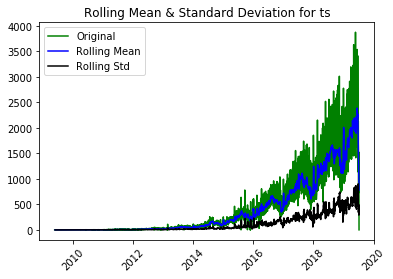

----------Dickey Fuller Test---------
Test Statistics:-1.5472
p-value:0.5100
Used Lags:30.0000
Number of observations:3666.0000
Critical Values: {'1%': -3.432135020388135, '5%': -2.862328722835932, '10%': -2.5671898489444147}


In [9]:
test_stationarity(df=df,ts='ts')

In [10]:
def plot_transformed_data(df,ts,ts_transform):
    """
    plot transformed and original time series data
    """
    f,ax = plt.subplots(1,1)
    ax.plot(df[ts])
    ax.plot(df[ts_transform],color='red')
    
    ax.set_title("%s and %s"%(ts,ts_transform))
    
    ax.tick_params(axis='x',rotation=45)
    ax.legend([ts,ts_transform])
    plt.show()
    plt.close()
    return

### Data Split

In [11]:
train = df[:-30]
test = df[-31:]
print(train.shape)
print(test.shape)
train = train.dropna()

(3667, 1)
(31, 1)


### Tranformation
* log(ts)
* 7 days moving average of log(ts)
* 7 days moving average 
* difference between logged ts and first order difference
* difference between ts and moving average of ts
* difference between logged ts and logged moving avergae
* logged exponentially weighted moving average(EWM)

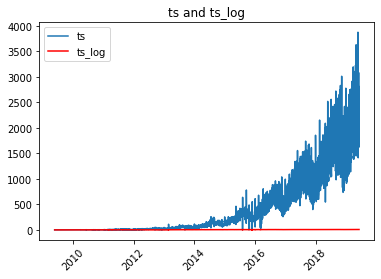

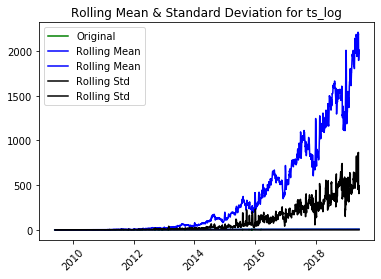

----------Dickey Fuller Test---------
Test Statistics:2.0934
p-value:0.9988
Used Lags:30.0000
Number of observations:3636.0000
Critical Values: {'1%': -3.4321497586963647, '5%': -2.8623352330844547, '10%': -2.5671933147833483}


In [12]:
# log(ts)
train['ts_log']=train['ts'].apply(lambda x:np.log(x))

plot_transformed_data(df = train, 
                      ts = 'ts', 
                      ts_transform = 'ts_log')
test_stationarity(df = train, 
                  ts = 'ts_log')

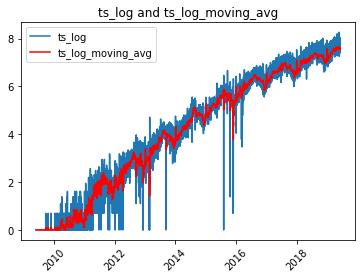

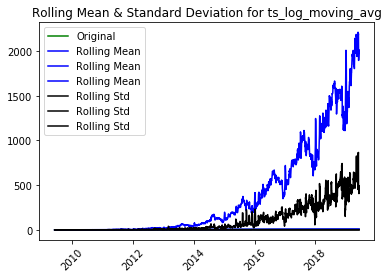

----------Dickey Fuller Test---------
Test Statistics:2.0934
p-value:0.9988
Used Lags:30.0000
Number of observations:3636.0000
Critical Values: {'1%': -3.4321497586963647, '5%': -2.8623352330844547, '10%': -2.5671933147833483}


In [13]:
# 7 days moving average of log(ts)

train['ts_log_moving_avg'] = train['ts_log'].rolling(window=7,
                                                       center=False).mean()
plot_transformed_data(df = train,
                      ts = 'ts_log', 
                      ts_transform='ts_log_moving_avg')
test_stationarity(df = train, 
                  ts = 'ts_log_moving_avg')

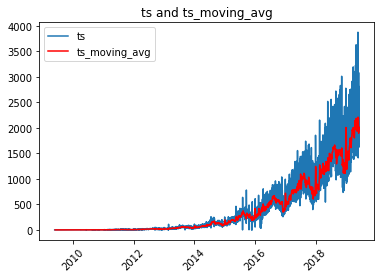

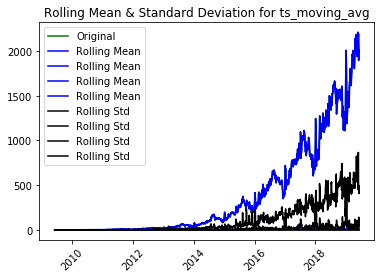

----------Dickey Fuller Test---------
Test Statistics:2.0934
p-value:0.9988
Used Lags:30.0000
Number of observations:3636.0000
Critical Values: {'1%': -3.4321497586963647, '5%': -2.8623352330844547, '10%': -2.5671933147833483}


In [14]:
# 7 days moving average

train['ts_moving_avg'] = train['ts'].rolling(window=7,
                                            center=False).mean()
plot_transformed_data(df=train,
                      ts='ts',
                      ts_transform='ts_moving_avg')
test_stationarity(df = train, 
                  ts = 'ts_moving_avg')

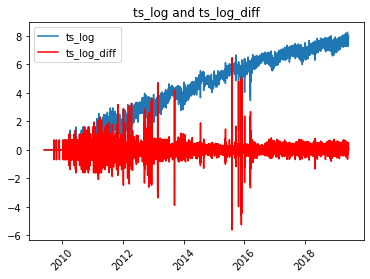

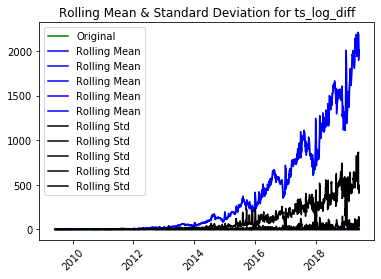

----------Dickey Fuller Test---------
Test Statistics:2.0934
p-value:0.9988
Used Lags:30.0000
Number of observations:3636.0000
Critical Values: {'1%': -3.4321497586963647, '5%': -2.8623352330844547, '10%': -2.5671933147833483}


In [15]:
# difference between logged ts and first order difference

train['ts_log_diff'] = train['ts_log'].diff()
plot_transformed_data(df=train,
                      ts='ts_log',
                      ts_transform='ts_log_diff')
test_stationarity(df = train, 
                  ts = 'ts_log_diff')

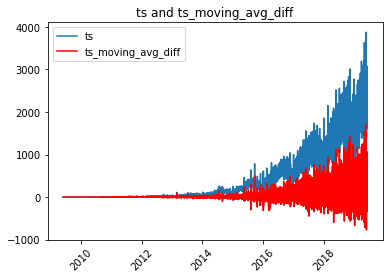

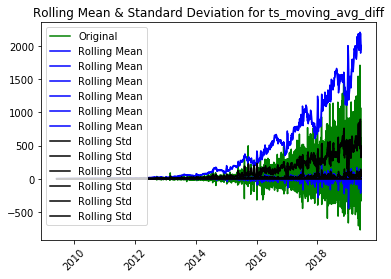

----------Dickey Fuller Test---------
Test Statistics:2.0934
p-value:0.9988
Used Lags:30.0000
Number of observations:3636.0000
Critical Values: {'1%': -3.4321497586963647, '5%': -2.8623352330844547, '10%': -2.5671933147833483}


In [16]:
# difference between ts and moving average of ts

train['ts_moving_avg_diff'] = train['ts']-train['ts'].rolling(window=7,center=False).mean()
plot_transformed_data(df=train,
                      ts='ts',
                      ts_transform='ts_moving_avg_diff')
test_stationarity(df = train, 
                  ts = 'ts_moving_avg_diff')

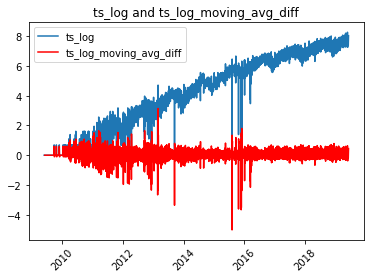

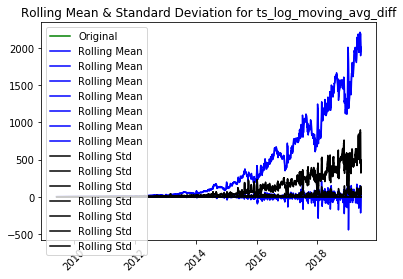

----------Dickey Fuller Test---------
Test Statistics:2.0934
p-value:0.9988
Used Lags:30.0000
Number of observations:3636.0000
Critical Values: {'1%': -3.4321497586963647, '5%': -2.8623352330844547, '10%': -2.5671933147833483}


In [17]:
# difference between logged ts and logged moving avergae

train['ts_log_moving_avg_diff'] = train['ts_log']-train['ts_log'].rolling(window=7,
                                                                          center=False).mean()
plot_transformed_data(df=train,
                      ts='ts_log',
                      ts_transform='ts_log_moving_avg_diff')
test_stationarity(df = train, 
                  ts = 'ts_log_moving_avg_diff')

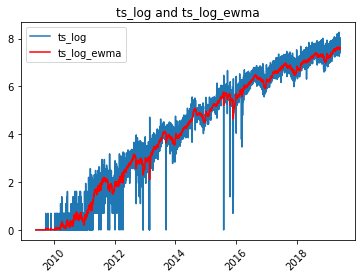

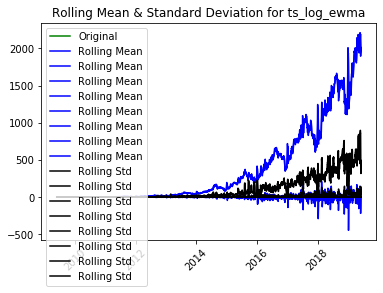

----------Dickey Fuller Test---------
Test Statistics:2.0934
p-value:0.9988
Used Lags:30.0000
Number of observations:3636.0000
Critical Values: {'1%': -3.4321497586963647, '5%': -2.8623352330844547, '10%': -2.5671933147833483}


In [18]:
# logged exponentially weighted moving average(EWM)
train['ts_log_ewma'] = train['ts_log'].ewm(halflife=7,
                                           ignore_na=False,
                                           min_periods=0,
                                           adjust=True).mean()
plot_transformed_data(df=train,
                      ts='ts_log',
                      ts_transform='ts_log_ewma')
test_stationarity(df = train, 
                  ts = 'ts_log_ewma')

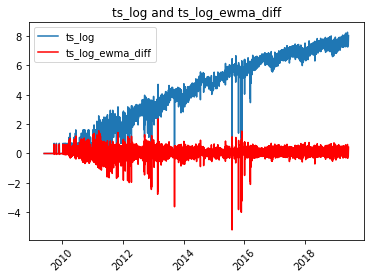

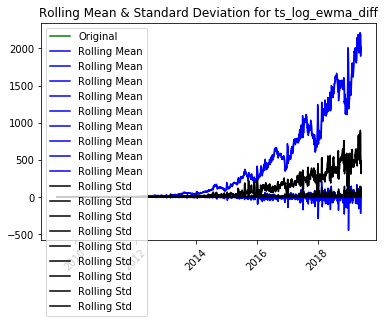

----------Dickey Fuller Test---------
Test Statistics:2.0934
p-value:0.9988
Used Lags:30.0000
Number of observations:3636.0000
Critical Values: {'1%': -3.4321497586963647, '5%': -2.8623352330844547, '10%': -2.5671933147833483}


In [19]:
# Difference between log and weigh
train['ts_log_ewma_diff'] = train['ts_log']-train['ts_log_ewma']
plot_transformed_data(df=train,
                      ts='ts_log',
                      ts_transform='ts_log_ewma_diff')
test_stationarity(df = train, 
                  ts = 'ts_log_ewma_diff')

### Decomposition
* De-trend and de-seasonalize data -> more stationary data

### Dickey Fuller Test
p(5%)<=0.05 - fail to reject the H0
* H0 - TSD is stationary

In [20]:
def plot_decomposition(df, ts, trend, seasonal, residual):
  """
  Plot time series data
  """
  f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15, 5), sharex = True)

  ax1.plot(df[ts], label = 'Original')
  ax1.legend(loc = 'best')
  ax1.tick_params(axis = 'x', rotation = 45)

  ax2.plot(df[trend], label = 'Trend')
  ax2.legend(loc = 'best')
  ax2.tick_params(axis = 'x', rotation = 45)

  ax3.plot(df[seasonal],label = 'Seasonality')
  ax3.legend(loc = 'best')
  ax3.tick_params(axis = 'x', rotation = 45)

  ax4.plot(df[residual], label = 'Residuals')
  ax4.legend(loc = 'best')
  ax4.tick_params(axis = 'x', rotation = 45)
  plt.tight_layout()

  # Show graph
  plt.suptitle('Trend, Seasonal, and Residual Decomposition of %s' %(ts), 
               x = 0.5, 
               y = 1.05, 
               fontsize = 18)
  plt.show()
  plt.close()
  
  return

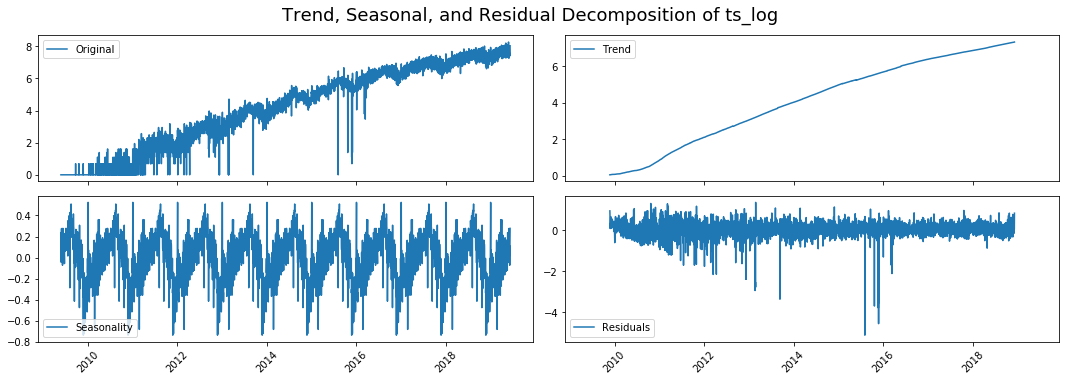

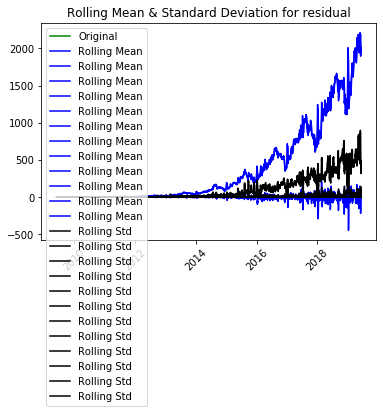

----------Dickey Fuller Test---------
Test Statistics:2.0934
p-value:0.9988
Used Lags:30.0000
Number of observations:3636.0000
Critical Values: {'1%': -3.4321497586963647, '5%': -2.8623352330844547, '10%': -2.5671933147833483}


In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition =seasonal_decompose(train['ts_log'],freq=365)

train.loc[:,'trend']=decomposition.trend
train.loc[:,'seasonal']=decomposition.seasonal
train.loc[:,'residual']=decomposition.resid

plot_decomposition(df=train,
                  ts='ts_log',
                  trend='trend',
                  seasonal='seasonal',
                  residual='residual')
test_stationarity(df=train,ts='residual')

In [22]:
def plot_acf_pacf(df, ts,lag_acf,lag_pacf):
  """
  Plot auto-correlation function (ACF) and partial auto-correlation (PACF) plots
  """
  f, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5)) 

  #Plot ACF: 

  ax1.plot(lag_acf)
  ax1.axhline(y=0,linestyle='--',color='gray')
  ax1.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.set_title('Autocorrelation Function for %s' %(ts))

  #Plot PACF:
  ax2.plot(lag_pacf)
  ax2.axhline(y=0,linestyle='--',color='gray')
  ax2.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.set_title('Partial Autocorrelation Function for %s' %(ts))
  
  plt.tight_layout()
  plt.show()
  plt.close()
  
  return

/Users/vamshi/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


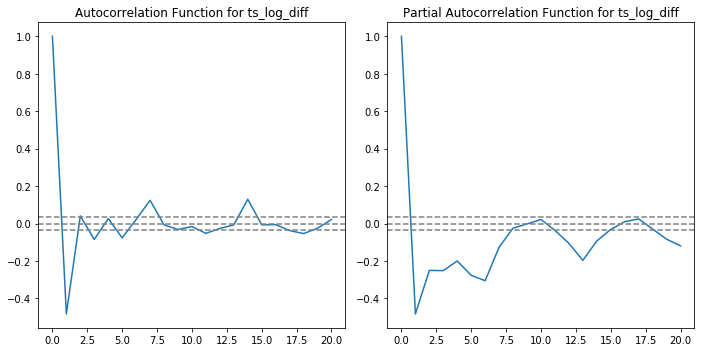

In [23]:
from statsmodels.tsa.stattools import acf,pacf
train = train.dropna()
lag_acf = acf(np.array(train['ts_log_diff']),nlags=20)
lag_pacf = pacf(np.array(train['ts_log_diff']),nlags=20)
# plt.plot(lag_acf)
# plt.plot(lag_pacf)
# plt.show()
# lag_acf
plot_acf_pacf(df=train,ts='ts_log_diff',lag_acf=lag_acf,lag_pacf=lag_pacf)

In [24]:
import itertools
import warnings
warnings.filterwarnings('ignore')

p = d = q = range(0, 5)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
for p,d,q in pdq:
    try:
        model = ARIMA(train['ts_log'],order=(p,d,q))
        results_ = model.fit(disp=-1)
        print("%i,%i,%i:%.4f"%(p,d,q,results_.aic))
    except:
        continue

0,0,0:14915.8554
0,0,1:11871.5845
0,0,2:9918.0345
0,0,3:9027.6269
0,0,4:8054.7280
0,1,0:6026.2809
0,1,1:4077.2057
0,1,2:4074.5989
0,2,0:9611.7711
0,2,1:6035.5608
1,0,0:5977.5421
1,0,1:4099.9648
1,0,2:4098.2154
1,0,3:4099.5410
1,0,4:4065.3420
1,1,0:5154.2338
1,1,1:4074.4792
1,1,2:4076.4526
1,1,3:4067.3901
1,1,4:4043.6695
1,2,0:7594.7473
1,2,4:4092.2211
2,0,0:5142.1463
2,0,1:4098.1481
2,0,2:4100.1413
2,0,3:4091.6988
2,0,4:4062.8829
2,1,0:4943.4939
2,1,1:4076.3003
2,1,2:4067.9336
2,1,3:3632.5532
2,1,4:3616.9733
2,2,0:6886.2226
2,2,4:4083.6630
3,0,0:4939.4112
3,0,1:4100.0966
3,0,2:4093.6731
3,0,3:3658.5115
3,0,4:3641.9258
3,1,0:4730.5227
3,1,1:4038.9509
3,1,2:4026.6569
3,1,3:3633.1882
3,1,4:3635.7761
3,2,0:6385.2768
4,0,0:4731.3622
4,0,1:4059.8514
4,0,2:4044.2860
4,0,3:nan
4,0,4:nan
4,1,0:4597.9815
4,1,1:4027.2889
4,1,2:4023.0931
4,1,3:3624.4571
4,1,4:nan
4,2,0:6160.3616


#### (p,d,q):AIC Score-->(2,1,4):3616.9733

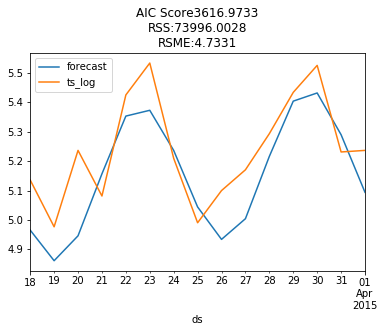

In [25]:
# Modeling with parameters 2,1,4 for AIC: 3616
model = ARIMA(train['ts_log'],order=(2,1,4))
results_ = model.fit(disp=-1)


len_results = len(results_.fittedvalues)
ts_modified = train['ts_log'][-len_results:]


# Plot Predict

# calculate root mean square error (RMSE) and residual sum of squares (RSS)
rss = sum((results_.fittedvalues - ts_modified)**2)
rmse = np.sqrt(rss / len(train['ts_log']))

results_.plot_predict(start='2015-03-18',
                      end='2015-04-01',
                      dynamic=False)
plt.title("AIC Score%.4f\nRSS:%.4f\nRSME:%.4f"%(results_.aic,rss,rmse))
plt.show()
plt.close()





(array([737219., 737223., 737227., 737231., 737235., 737239., 737241.,
        737245., 737249.]), <a list of 9 Text xticklabel objects>)

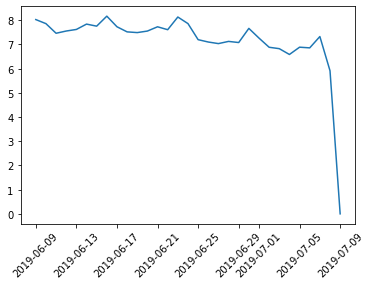

In [26]:
test['ts_log']=test['ts'].apply(lambda x:np.log(x))
plt.plot(test['ts_log'])
plt.xticks(rotation=45)

In [27]:
def plot_prediction(df,ts):
        actual = df[ts]
        forecast_period = len(actual)
        pred = results_.forecast(forecast_period)[0]
        pred = pd.Series(pred,index=actual.index)
        rss = rss = sum((actual-pred)**2)
        rsme = np.sqrt(rss / len(test['ts_log']))
        plt.plot(pred,color='red',label='Prediction')
        plt.plot(actual,color='blue',label='Actual value')
        plt.title("Actual vs Prediction RSS:%f, RSME:%f"%(rss,rsme))
        plt.xticks(rotation=45)
        plt.legend(loc='best')
        plt.show()
        plt.close()
        return
    




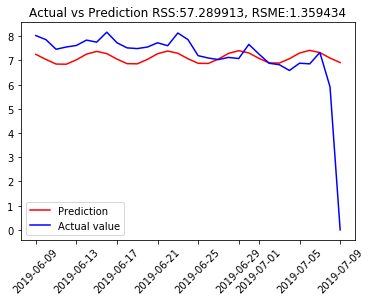

In [28]:
plot_prediction(df=test,ts='ts_log')